# Line Segment Merging
![spiderweb](../results/demo_stick/bighough_w5_1080.png)

In [2]:
import skimage as img
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
# %matplotlib notebook
from skimage import io
from skimage import filters
plt.rcParams["figure.figsize"] = (15,10)
import os
import json
import itertools
import multiprocessing as mp
import sys

## Merging test
Now we have fitted lines from the Hough transform, it would be good to simplify the shape to reduce the computational complexity of dealing with this web kernel.

Let's first find out how many lines we have (each line is 2 tuples of 2 numbers).

In [3]:
indir = "demo_stick"
with open(os.path.join("../data/full_web_kernel.json"), "r") as f:
    web_dict = json.load(f)
web_lines = web_dict["lines"]

In [55]:
web_dict["dimensions"]

[2816, 2112]

In [4]:
len(web_lines)

3476

In [5]:
web_lines[0]

[[564, 822], [543, 814]]

In [6]:
def line_length(line):
    return ((line[0][0] - line[1][0])**2 + (line[0][1] - line[1][1])**2)**0.5

Let's quickly have a peek at the current distribution of line lengths in this image.

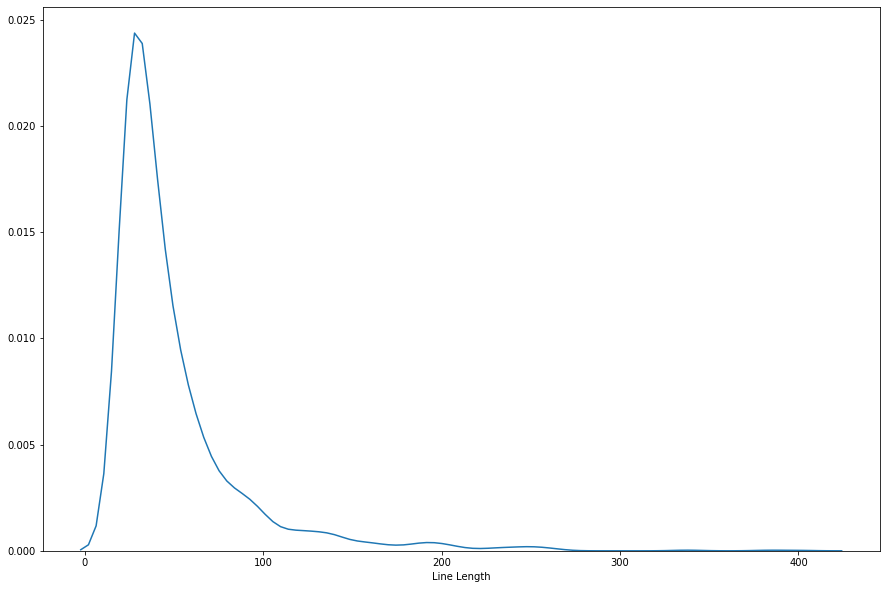

In [7]:
web_line_lengths = [line_length(x) for x in web_lines]

import seaborn as sns
sns.distplot(web_line_lengths, hist=False, kde=True, axlabel="Line Length")
plt.show()

In [8]:
np.median(web_line_lengths)

36.40054944640259

As expected, most of the lengths are short, with a median length of only 37 px.

For testing the [Tavares & Padliha](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.217.9430&rep=rep1&type=pdf) segment merge algorithm, let's define two arbitrary lines.

In [9]:
test_lines = (
    ((2, 2), (5, 5)),
    ((3, 1), (4, 3))
)

In [10]:
test_lines = (
    ((1, 2), (4, 5)),
    ((2, 1), (5, 3))
)

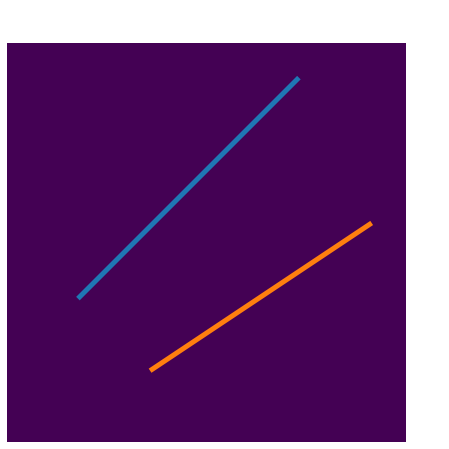

In [11]:
demofig = np.full((6,6), 0, dtype=np.uint8)

fig,ax = plt.subplots(1, figsize=(8,8))
ax.imshow(demofig)
for line in test_lines:
    p0, p1 = line
    ax.plot((p0[0], p1[0]), (p0[1], p1[1]), lw=5)
ax.set_xlim((0, demofig.shape[1]))
ax.set_ylim((0, demofig.shape[0]))

ax.axis('off')
plt.show()

### Tavares & Padliha Algorithm
#### Centroid
Define the coordinates of the centroid - $(x_G,y_G$) - of the set formed by the four endpoints, taking the respective segment lengths - $l_i$ and $l_j$ - as the point "masses", that is

$$x_G = \frac{l_i(a_x+b_x)+l_j(c_x+d_x)}{2(l_i+l_j)}$$

$$y_G = \frac{l_i(a_y+b_y)+l_j(c_y+d_y)}{2(l_i+l_j)}$$

where $(a,b)$ are the endpoints of segment $i$ and $(c,d)$ are the endpoints of segment $j$. The merged line will contain this centroid. 

In [12]:
def find_centroid(line1, line2):
    li = line_length(line1)
    lj = line_length(line2)
    
    xG = (li * (line1[0][0] + line1[1][0]) + lj * (line2[0][0] + line2[1][0]))/(2 * (li + lj))
    yG = (li * (line1[0][1] + line1[1][1]) + lj * (line2[0][1] + line2[1][1]))/(2 * (li + lj))
    return (xG, yG)

In [13]:
test_centroid = find_centroid(test_lines[0], test_lines[1])
print(test_centroid)

(2.9594117081556712, 2.810882437766494)


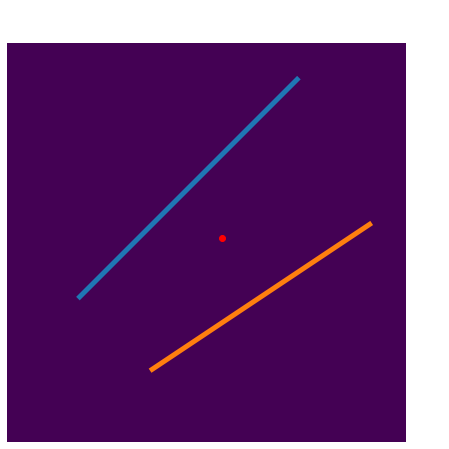

In [14]:
demofig = np.full((6,6), 0, dtype=np.uint8)

fig,ax = plt.subplots(1, figsize=(8,8))
ax.imshow(demofig)
for line in test_lines:
    p0, p1 = line
    ax.plot((p0[0], p1[0]), (p0[1], p1[1]), lw=5)
ax.plot(*test_centroid, 'ro')
ax.set_xlim((0, demofig.shape[1]))
ax.set_ylim((0, demofig.shape[0]))

ax.axis('off')
plt.show()

#### Orientation
Define the orientation of the merged line as the weighted sum of the orientations of the given segments, taking for weights their respective lengths. The orientation of the merged line - $\theta_r$ - is thus given by 

If...

$$\lvert\theta_i-\theta_j\rvert\leq\frac{\pi}{2}$$

then...

$$\theta_r = \frac{l_i\theta_i + l_j\theta_j}{l_i + l_j}$$

else...

$$\theta_r = \frac{l_i\theta_i + l_j\left(\theta_j-\pi\frac{\theta_j}{\lvert\theta_j\rvert} \right)}{l_i + l_j}$$

where $l_k$ and $\theta_k$ represent the length and direction of segment $k$, respectively.

In [15]:
def find_line_orientation(line, degrees=False):
        '''get orientation of a line
        https://en.wikipedia.org/wiki/Atan2
        '''
#         l1 = line_length(((0,0), line[0]))
#         l2 = line_length(((0,0), line[1]))
#         if l2 > l1:
#             line = (line[1], line[0])
        orientation = np.arctan2((line[0][1] - line[1][1]), (line[0][0] - line[1][0]))
        if degrees:
            return math.degrees(orientation)
        return orientation

In [16]:
find_line_orientation(((0, 0), (1, 0)))
# find_line_orientation(test_lines[0])

3.141592653589793

In [17]:
li = line_length(test_lines[0])
lj = line_length(test_lines[1])
thetai = find_line_orientation(test_lines[0])
thetaj = find_line_orientation(test_lines[1])
print("{}, {}".format(thetai, thetaj))
if abs(thetai - thetaj) <= (np.pi / 2):
    thetar = (li * thetai + lj * thetaj) / (li + lj)
else:
    thetar = (li * thetai + lj * (thetaj - np.pi * (thetaj / abs(thetaj)))) / (li + lj)
thetar

-2.356194490192345, -2.5535900500422257


-2.446880321525324

#### Frame
Define a frame $(X_G,Y_G)$ centered on the centroid $(x_G,y_G)$ and having the $X_G$ axis parallel to the direction $\theta_r$ of the merged line. 

#### Endpoints
Determine the coordinates of the endpoints $a, b, c$ and $d$ of both segments in the frame $(X_G,Y_G)$.

The coordinate transformation is a translation followed by a rotation:

$$\delta_{XG}=(\delta_y-y_G)\sin\theta_r+(\delta_x-x_G)\cos\theta_r$$

$$\delta_{YG}=(\delta_y-y_G)\cos\theta_r-(\delta_x-x_G)\sin\theta_r$$

where $(\delta_{XG},\delta_{YG})$ are the coordinates of the point $\delta$ in frame $(X_G,Y_G)$

In [18]:
def point_to_framespace(point, centroid, orientation):
    dXG = (point[1] - centroid[1]) * np.sin(orientation) + (point[0] - centroid[0])*np.cos(orientation)
    dYG = (point[1] - centroid[1]) * np.cos(orientation) - (point[0] - centroid[0])*np.sin(orientation)
    return (dXG, dYG)

def lines_to_framespace(lines, centroid, orientation):
    return [[point_to_framespace(point, centroid, orientation) for point in line] for line in lines]

In [19]:
transformed_lines = lines_to_framespace(test_lines, test_centroid, thetar)
# Now merge to one list of coordinates
transformed_points = [item for sublist in transformed_lines for item in sublist]

# Find min and max X value in transformed space, set y = 0
minval, minidx = min((val, idx) for (idx, val) in enumerate([x[0] for x in transformed_points]))
maxval, maxidx = max((val, idx) for (idx, val) in enumerate([x[0] for x in transformed_points]))
print(transformed_points)
print(minval, maxval)

[(2.024392437997836, -0.6313951432445726), (-2.200814632948508, -1.0156154025035211), (1.8963190182448533, 0.7770072137375421), (-1.688723584086925, 1.1610248428461425)]
-2.200814632948508 2.024392437997836


#### Projection
The two orthogonal projections over the axis $X_G$ of the four endpoints $a, b, c$ and $d$, which are farther apart, define the endpoints of the merged line.
##### Rearrangement of equations

In [20]:
from sympy import *
init_printing()

In [21]:
d_XG = var("\\delta_{XG}")
d_YG = var("\\delta_{YG}")
d_x = var("\\delta_x")
d_y = var("\\delta_y")
y_G = var("y_G")
x_G = var("x_G")
t_r = var("\\theta_r")

# Solve iterable of both equations (set to 0) 

solutions = solve(((d_y-y_G)*sin(t_r)+(d_x-x_G)*cos(t_r) - d_XG, (d_y-y_G)*cos(t_r)-(d_x-x_G)*sin(t_r) - d_YG), d_x, d_y, set=True)
solutions

In [22]:
 init_printing(pretty_print=False)

Thus the back-transform equations are as follows.

$$\delta_x = \delta_{XG}cos(\theta_r) - \delta_{YG}sin(\theta_r) + x_G$$

$$\delta_y = \delta_{XG}sin(\theta_r) + \delta_{YG}cos(\theta_r) + y_G$$

---
Calculation by hand (thanks to Lucas):

$$\begin{pmatrix} \delta_{XG} \\ \delta_{YG} \end{pmatrix} = \begin{pmatrix} \cos{\theta_r} & \sin{\theta_r} \\ -\sin{\theta_r} & \cos{\theta_r}\end{pmatrix}\begin{pmatrix} \delta_{x}-X_G \\ \delta_{y}-Y_G \end{pmatrix}$$

The transformed representation of point $X$ is found with a translation followed by a rotation of $\theta_r$:

$$\vec{X_T} = R(\theta_r)(\vec{X} - \vec{X_G})$$

$$R^{-1}(\theta_r)\vec{X_T} = \vec{X} - \vec{X_G}$$

$$\vec{X} = \vec{X_G} + R^{-1}(\theta_r)\vec{X_T}$$

$$\vec{X} = \begin{pmatrix} X_G \\ Y_G \end{pmatrix} + \begin{pmatrix} \cos{-\theta_r} & \sin{-\theta_r} \\ -\sin{-\theta_r} & \cos{-\theta_r}\end{pmatrix}\begin{pmatrix} \delta_{XG} \\ \delta_{YG} \end{pmatrix}$$

As the following:
$$\cos{-x} = \cos{x}\\\sin{-x} = -\sin{x}$$

then

$$\begin{pmatrix} \delta_{x} \\ \delta_{y} \end{pmatrix} = \begin{pmatrix} X_G \\ Y_G \end{pmatrix} + \begin{pmatrix} \cos{\theta_r} & -\sin{\theta_r} \\ \sin{\theta_r} & \cos{\theta_r}\end{pmatrix}\begin{pmatrix} \delta_{XG} \\ \delta_{YG} \end{pmatrix}$$

$\therefore$

$$\delta_x = x_G + cos(\theta_r)\delta_{XG} - sin(\theta_r)\delta_{YG}$$

$$\delta_y = y_G + sin(\theta_r)\delta_{XG} + cos(\theta_r)\delta_{YG}$$

---

In [23]:
def point_from_framespace(point, centroid, orientation):
    dx = centroid[0] + np.cos(orientation)*point[0] - np.sin(orientation)*point[1]
    dy = centroid[1] + np.sin(orientation)*point[0] + np.cos(orientation)*point[1]
    return (dx, dy)

In [24]:
merged_line = (point_from_framespace((minval, 0), test_centroid, thetar),point_from_framespace((maxval, 0), test_centroid, thetar))
merged_line

((4.650160894460435, 4.219765767787137), (1.4041967363609797, 1.5149383284282636))

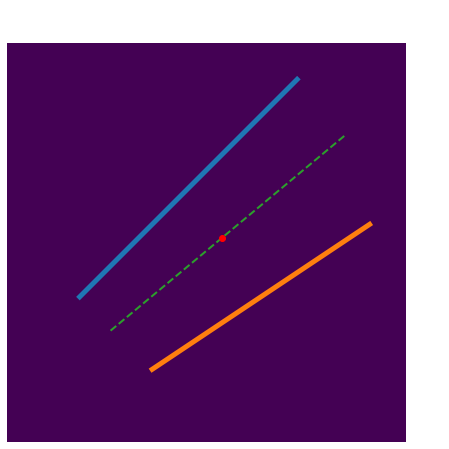

In [25]:
fig,ax = plt.subplots(1, figsize=(8,8))
ax.imshow(demofig)
for line in test_lines:
    p0, p1 = line
    ax.plot((p0[0], p1[0]), (p0[1], p1[1]), lw=5)
ax.plot((merged_line[0][0], merged_line[1][0]), (merged_line[0][1], merged_line[1][1]), lw=2, ls='--')
ax.plot(*test_centroid, 'ro')
ax.set_xlim((0, demofig.shape[1]))
ax.set_ylim((0, demofig.shape[0]))

ax.axis('off')
plt.show()

### Nice usable wrapper function

In [35]:
class MergeError(Exception):
    pass

def merge_line_segments(line1, line2, dmax_x=None, dmax_y=None, dmax_y_o=None, dmax_y_p=None):
    """Merge line segments using the Tavares & Padliha algorithm"""
    centroid = find_centroid(line1, line2)
    
    # Find orientation
    li = line_length(line1)
    lj = line_length(line2)
    thetai = float(find_line_orientation(line1))
    thetaj = float(find_line_orientation(line2))

    
    
    if abs(thetai - thetaj) <= (np.pi / 2):
        thetar = (li * thetai + lj * thetaj) / (li + lj)
    else:
        if thetaj == 0:
            # If thetaj is 0 then assume that 0/0 == 1, rather than nan or inf.
            # This could be tricky in the scenario that thetaj = -0
            thetar = (li * thetai + lj * (thetaj - np.pi)) / (li + lj)
        else:
            thetar = (li * thetai + lj * (thetaj - np.pi * (thetaj / abs(thetaj)))) / (li + lj)
        
    
    # Transform lines to framespace
    transformed_lines = lines_to_framespace((line1, line2), centroid, thetar)
    # ---
    # Now merge to one list of coordinates
    transformed_points = [item for sublist in transformed_lines for item in sublist]
    
    xs, ys = zip(*transformed_points)
    minx = int(min(xs))
    maxx = int(max(xs))
#     miny = int(min(ys))
#     maxy = int(max(ys))        
#     l1_X_G = abs(transformed_lines[0][1][0] - transformed_lines[0][0][0])
#     l2_X_G = abs(transformed_lines[1][1][0] - transformed_lines[1][0][0])

    lr = maxx - minx
    
    # Set working dmax_y value to the same as dmax_y. If dmax_y is also None then it doesn't matter.
#     dmax_y_working = dmax_y
    
#     if lr >= (l1_X_G + l2_X_G):
#         # Not Overlapping!
#         # Test dmax_x only in the case that candidate lines are not overlapping
#         if dmax_x is not None:
#             if (lr - (l1_X_G + l2_X_G)) > dmax_x:
#                 raise MergeError("X distance outside maximum threshold value. {} > {}".format((lr - (l1_X_G + l2_X_G)), dmax_x))            
                

#     elif np.isclose(lr, l1_X_G) or np.isclose(lr, l2_X_G):
#         # Here we use isclose rather than == due to minor rounding errors when transforming to framespace
#         # Fully Overlapping!
#         # If dmax_y for overlapping has been specified, use that, otherwise leave as normal dmax_y
#         if dmax_y_o is not None:
#             dmax_y_working = dmax_y_o

#     elif lr < (l1_X_G + l2_X_G):
#         # Partially Overlapping!
#         # If dmax_y for partial has been specified, use that, otherwise leave as normal dmax_y
#         if dmax_y_p is not None:
#             dmax_y_working = dmax_y_p
#     else:
#         print("Inconclusively Overlapping.")
#         raise MergeError("Overlap of lines could not be conclusively evaluated.")
    
#     if dmax_y_working is not None:
#         if abs(maxy - miny) > dmax_y_working:
#             raise MergeError("Y distance outside maximum threshold value. {} > {}".format(abs(maxy - miny), dmax_y_working))
    
    # Retransform min and max values back to normal space
    merged_line = (point_from_framespace((minx, 0), centroid, thetar),point_from_framespace((maxx, 0), centroid, thetar))
    return merged_line

In [27]:
new_test_lines = (((1,1), (6,3)), ((6,2), (9,9)))
new_merged_line = merge_line_segments(*new_test_lines, dmax_x = 10)
print(new_merged_line)

((9.17829251725344, 7.775409715527475), (2.5079989837617997, 0.3250953478608598))


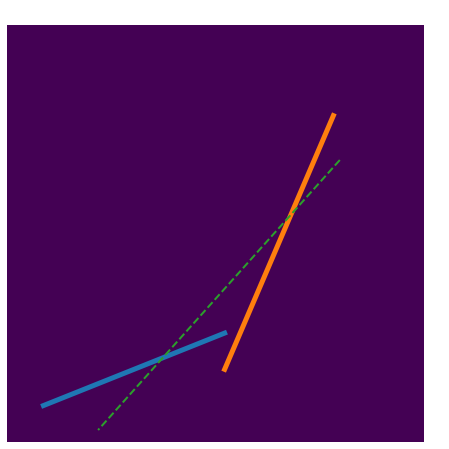

In [28]:
demofig = np.full((12,12), 0, dtype=np.uint8)
fig,ax = plt.subplots(1, figsize=(8,8))
ax.imshow(demofig)
for line in new_test_lines:
    p0, p1 = line
    ax.plot((p0[0], p1[0]), (p0[1], p1[1]), lw=5)
ax.plot((new_merged_line[0][0], new_merged_line[1][0]), (new_merged_line[0][1], new_merged_line[1][1]), lw=2, ls='--')
ax.set_xlim((0, demofig.shape[1]))
ax.set_ylim((0, demofig.shape[0]))

ax.axis('off')
plt.show()

## Fun Tester

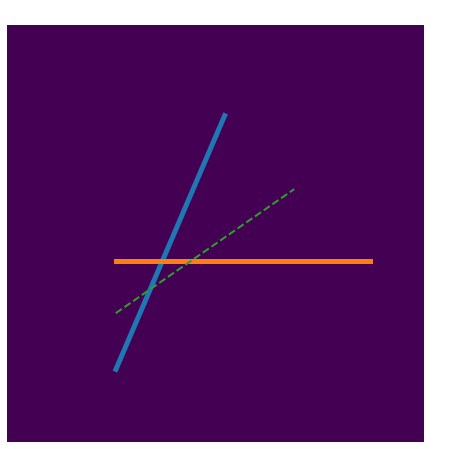

In [76]:
rng = np.random.default_rng()
coords = rng.integers(1, 11, size=8)

new_test_lines = (((coords[0:2]), (coords[2:4])), (coords[4:6], coords[6:8]))
new_merged_line = merge_line_segments(*new_test_lines)

demofig = np.full((12,12), 0, dtype=np.uint8)
fig,ax = plt.subplots(1, figsize=(8,8))
ax.imshow(demofig)
for line in new_test_lines:
    p0, p1 = line
    ax.plot((p0[0], p1[0]), (p0[1], p1[1]), lw=5)
ax.plot((new_merged_line[0][0], new_merged_line[1][0]), (new_merged_line[0][1], new_merged_line[1][1]), lw=2, ls='--')
ax.set_xlim((0, demofig.shape[1]))
ax.set_ylim((0, demofig.shape[0]))

ax.axis('off')
plt.show()

In [53]:
def gen_lines(n):
    coords_n = n*4
    coords = rng.integers(1, 100, size=coords_n)
    return [x for x in chunks([x for x in chunks(coords, 2)],2)]
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [54]:
new_test_lines = gen_lines(2)
%timeit -n 100 -r 100 new_merged_line = merge_line_segments(*test_lines)

26.6 µs ± 1.73 µs per loop (mean ± std. dev. of 100 runs, 100 loops each)


## Further ideas
- Harris corner detection?
- Use [texture classification](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_multiblock_local_binary_pattern.html#sphx-glr-auto-examples-features-detection-plot-multiblock-local-binary-pattern-py).
- Check for areas for high complexity.
- Line reprojection
    - Project each line to edge of image.
    - Increment each pixel which the line touches
    - Find the place with the highest total?

In [28]:
class WebLine():
    def __init__(self, line, orientation=None, length=None):
        self.line = line
        
        if orientation:
            self.orientation = orientation
        else:
            self.orientation = self.find_orientation()
        
        if length:
            self.length = length
        else:
            self.length = self.find_length()
    
    def __repr__(self):
        return "{0}({1})".format(self.__class__.__name__, self.line)
    
    def __str__(self):
        return "{0}\nLength: {1}\nOrientation: {2}".format(self.line, self.length, self.orientation)
    
    # Implement getitem to allow indexing the line to get out the points easily
    def __getitem__(self, i):
        return self.line[i]
    
#     def __len__(self):
#         return len(self.line)
    
    def find_orientation(self):
        return find_line_orientation(self.line)
    
    def find_length(self):
        return line_length(self.line)
    
#     def find_merge_candidates(self):
#         raise NotImplementedError
    
    def export(self):
        return self.line

testline = WebLine(new_test_lines[0])
print(testline)
print(testline[0])

((1, 1), (6, 3))
Length: 5.385164807134504
Orientation: -2.761086276477428
(1, 1)


In [29]:
def find_orientation_difference(line1, line2, absolute=True):
    """Find the smallest orientation difference between two lines, """
    if isinstance(line1, WebLine):
        l1_theta = line1.orientation
    else:
        l1_theta = find_line_orientation(line1)
    if isinstance(line2, WebLine):
        l2_theta = line2.orientation
    else:
        l2_theta = find_line_orientation(line2)
    
    a = (l1_theta - l2_theta) % (np.pi*2)
    b = (l2_theta - l1_theta) % (np.pi*2)
#     print(a)
#     print(b)
    out = -a if a < b else b
    if absolute:
        return abs(out)
    else:
        return out

testline2 = WebLine(new_test_lines[1])
print(testline)
print(testline2)
find_orientation_difference([[1,1],[6,6]], [[6,6],[0,1]])

((1, 1), (6, 3))
Length: 5.385164807134504
Orientation: -2.761086276477428
((6, 2), (9, 9))
Length: 7.615773105863909
Orientation: -1.97568811307998


3.0509327663890478

When using this function we MUST remember two things.
1. As the value has been made absolute, when specifying a threshold we must remember that it technically covers that distance either side of 0, so is double the specified angle threshold.
2. We must also test whether $\pi - \Delta\theta <$ _threshold_ as the lines could be orientated in parallel but opposite directions.

In [30]:
def mergable(line1, line2, threshold=np.pi/20):
    """Check if two lines can be merged. Default threshold provides 10% coverage (maybe 20%)"""
    if line1[0] == line1[1] or line2[0] == line2[1]:
        raise ValueError("Lines cannot have the same start and end coordinates.")
    if line1[0] in line2 and line1[1] in line2:
        return False
    orientation_delta = find_orientation_difference(line1, line2)
    if orientation_delta <= threshold:
        return True
    elif (np.pi-orientation_delta) <= threshold:
        return True
    else:
        return False

In [31]:
mergable([[1,1], [3,3]], [[3,3], [2,2]])

True

In [32]:
class WebKernel():
    def __init__(self, webdict=None):
        if webdict:
            self.webdict = webdict
            self.lines = [WebLine(x) for x in self.webdict["lines"]]
            self.dimensions = self.webdict.get("dimensions", self.find_dimensions())
            self.remove_zero_lines()
        else:
            self.webdict = dict()
            self.lines = []
            self.dimensions = []
    def __len__(self):
        return len(self.lines)
    
    def __getitem__(self, i):
        return self.lines[i]
    
    def __str__(self):
        if len(self.lines):
            return "Web Kernel of {0} lines, ({1}x{2})".format(len(self.lines), *self.dimensions)
        else:
            return "Empty Web Kernel"
    
    def __repr__(self):
        return "{0}({1})".format(self.__class__.__name__, self.webdict)

    def find_dimensions(self):
        """Find minimum dimensions of a web kernel"""
        flattened = [item for sublist in self.lines for item in sublist]
        xs, ys = zip(*flattened)
        dimx = int(max(xs))
        dimy = int(max(ys))
        return [dimx, dimy]
    
    def remove_zero_lines(self):
        self.lines = [x for x in self.lines if x.length > 0]
    
    def find_merge_candidates(self):
        candidates = list(itertools.combinations(self.lines, 2))
        print(len(candidates))
        candidates = [c for c in candidates if mergable(*c)]
        print(len(candidates))
        return candidates
#         print(len(candidates))
        # Find all pairings
    
    def as_dict(self):
        """Export a Web Kernel as a dictionary"""
        return {"dimensions": self.dimensions, "lines": [line.export() for line in self.lines]}

webpack = WebKernel(web_dict)
print(webpack)
print(webpack.find_merge_candidates()[0])

Web Kernel of 3476 lines, (2816x2112)
6039550
848010
(WebLine([[564, 822], [543, 814]]), WebLine([[1304, 1099], [1273, 1089]]))


In [33]:
mergetest_lines = webpack.lines
print(mergetest_lines[0])

[[564, 822], [543, 814]]
Length: 22.47220505424423
Orientation: 0.36397895650964407


## Remade merge_line_segments

In [144]:
class MergeError(Exception):
    pass

def merge_line_segments(line1, line2, dmax_x=None, dmax_y=None, dmax_y_o=None, dmax_y_p=None):
    """Merge line segments using the Tavares & Padliha algorithm"""
    centroid = find_centroid(line1, line2)
    
    lrmin = 50
    
    # Find orientation
    if isinstance(line1, WebLine):
        thetai = line1.orientation
        li = line1.length
    else:
        thetai = find_line_orientation(line1)
        li = line_length(line1)

    if isinstance(line2, WebLine):
        thetaj = line2.orientation
        lj = line2.length
    else:
        thetaj = find_line_orientation(line2)
        lj = line_length(line2)
        
    thetai = float(thetai)
    thetaj = float(thetaj)
    
    
    if abs(thetai - thetaj) <= (np.pi / 2):
        thetar = (li * thetai + lj * thetaj) / (li + lj)
    else:
        if thetaj == 0:
            # If thetaj is 0 then assume that 0/0 == 1, rather than nan or inf.
            # This could be tricky in the scenario that thetaj = -0
            thetar = (li * thetai + lj * (thetaj - np.pi)) / (li + lj)
        else:
            thetar = (li * thetai + lj * (thetaj - np.pi * (thetaj / abs(thetaj)))) / (li + lj)
        
    
    # Transform lines to framespace
    transformed_lines = lines_to_framespace((line1, line2), centroid, thetar)
    # ---
    # Now merge to one list of coordinates
    transformed_points = [item for sublist in transformed_lines for item in sublist]
    
    xs, ys = zip(*transformed_points)
    minx = int(min(xs))
    maxx = int(max(xs))
    miny = int(min(ys))
    maxy = int(max(ys))        
    l1_X_G = abs(transformed_lines[0][1][0] - transformed_lines[0][0][0])
    l2_X_G = abs(transformed_lines[1][1][0] - transformed_lines[1][0][0])

    lr = maxx - minx
    
#     if lr < lrmin:
#         raise MergeError("Line too small.")
    
    # Set working dmax_y value to the same as dmax_y. If dmax_y is also None then it doesn't matter.
    dmax_y_working = dmax_y
#     print("dmax_x = {}".format(dmax_x))
    
    if lr >= (l1_X_G + l2_X_G):
        # Not Overlapping!
#         print("Not Overlapping!")
        # Test dmax_x only in the case that candidate lines are not overlapping
        if dmax_x is not None:
            if (lr - (l1_X_G + l2_X_G)) > dmax_x:
                raise MergeError("X distance outside maximum threshold value. {} > {}".format((lr - (l1_X_G + l2_X_G)), dmax_x))            
                

    elif np.isclose(lr, l1_X_G) or np.isclose(lr, l2_X_G):
        # Here we use isclose rather than == due to minor rounding errors when transforming to framespace
        # Fully Overlapping!
#         print("Fully Overlapping!")
        # If dmax_y for overlapping has been specified, use that, otherwise leave as normal dmax_y
        if dmax_y_o is not None:
            dmax_y_working = dmax_y_o

    elif lr < (l1_X_G + l2_X_G):
        # Partially Overlapping!
#         print("Partially Overlapping!")
        # If dmax_y for partial has been specified, use that, otherwise leave as normal dmax_y
        if dmax_y_p is not None:
            dmax_y_working = dmax_y_p
    else:
        print("Inconclusively Overlapping.")
        raise MergeError("Overlap of lines could not be conclusively evaluated.")
    
#     print("dmax_x = {}, dmax_y = {}".format(dmax_x, dmax_y_working))
    if dmax_y_working is not None:
        if abs(maxy - miny) > dmax_y_working:
            raise MergeError("Y distance outside maximum threshold value. {} > {}".format(abs(maxy - miny), dmax_y_working))
    
    # Retransform min and max values back to normal space
    merged_line = WebLine([point_from_framespace((minx, 0), centroid, thetar),point_from_framespace((maxx, 0), centroid, thetar)], thetar, lr)
#     merged_line = (point_from_framespace((minx, 0), centroid, thetar),point_from_framespace((maxx, 0), centroid, thetar))
    return merged_line

In [145]:
def merge_line_segments_wrapper(line1, line2, theta_threshold=np.pi/20, dmax_x=None, dmax_y=None, dmax_y_o=None, dmax_y_p=None):
        """Wrapper around merge_line_segments to allow easy parallelisation"""
        if mergable(line1, line2, theta_threshold):
            try:
                return merge_line_segments(line1, line2, dmax_x, dmax_y, dmax_y_o, dmax_y_p)
            except MergeError:
                return None
        else:
#             print("Orientation Mismatch")
            return None

In [146]:
def _find_candidates(lines):
    candidates = list(itertools.combinations(lines, 2))
    candidates = [c for c in candidates if mergable(*c)]
    merged = [merge_line_segments(*c) for c in candidates]

# %timeit -n 1 -r 1 _find_candidates(mergetest_lines)
# %timeit -n 6 -r 10 _find_candidates(mergetest_lines)
# 58.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each) - merge

In [147]:
def _find_candidates2(lines):
    candidates = [c for c in itertools.combinations(lines, 2) if mergable(*c)]
    merged = [merge_line_segments(*c) for c in candidates]

# %timeit -n 6 -r 10 _find_candidates2(mergetest_lines)

In [148]:
def _find_candidates_parallel(lines, theta_threshold=np.pi/20, dmax_x=None, dmax_y=None, dmax_y_o=None, dmax_y_p=None):
    candidates = list(itertools.combinations(lines, 2))

    pool = mp.Pool(mp.cpu_count())

    results = []
    results = pool.starmap_async(merge_line_segments_wrapper, [(*c, theta_threshold, dmax_x, dmax_y, dmax_y_o, dmax_y_p) for c in candidates], chunksize=int(len(candidates)/mp.cpu_count())).get()
    
    pool.close()
    results = [r for r in results if r is not None]
    return results

# %timeit -n 1 -r 1 _find_candidates_parallel(mergetest_lines)
# %timeit -n 6 -r 10 _find_candidates_parallel(mergetest_lines)
#30.1 s ± 1.09 s per loop (mean ± std. dev. of 4 runs, 5 loops each) - find and merge
#29.3 s ± 661 ms per loop (mean ± std. dev. of 4 runs, 5 loops each) - find only
#29.7 s ± 149 ms per loop (mean ± std. dev. of 4 runs, 5 loops each) - chunksize=int(len(candidates)/mp.cpu_count()/2)
# results = _find_candidates_parallel(mergetest_lines, np.pi/40, 1, 1, 1, 1)

In [95]:
len(results)

3948

In [ ]:
# do as above but preprocess using "mergable" to reduce down working iterable before merging
def _find_candidates_parallel2(lines):
    candidates = [c for c in itertools.combinations(line

In [41]:
# do as above but preprocess using "mergable" to reduce down working iterable before merging
def _find_candidates_parallel2(lines):
    candidates = [c for c in itertools.combinations(lines, 2) if mergable(*c)]
    
    # Use starmap_async to parallelise merging.
    pool = mp.Pool(mp.cpu_count())

    results = []
#     kwargs = [
#         "theta_threshold": np.pi/20,
#         "dmax_x": None,
#         "dmax_y": None,
#         "dmax_y_o": None,
#         "dmax_y_p": None,
#     ]
    results = pool.starmap_async(merge_line_segments, candidates, chunksize=int(len(candidates)/mp.cpu_count())).get()

    # With map, use `howmany_within_range_rowonly` instead
    # results = pool.map_async(howmany_within_range_rowonly, [row for row in data]).get()

    pool.close()
    return results

%timeit -n 6 -r 10 _find_candidates_parallel2(mergetest_lines)
# 39.1 s ± 516 ms per loop (mean ± std. dev. of 4 runs, 3 loops each)
# results2 = _find_candidates_parallel2(mergetest_lines)

35 s ± 63.2 ms per loop (mean ± std. dev. of 10 runs, 6 loops each)


**For a web of 3476 lines**

| Combination Generation | Orientation & Sanity Check |  Merge   | Results Filter | Timing |
|:----------------------:|:--------------------------:|:--------:|:--------------:|:------:|
|         Serial         |           Serial           |  Serial  |      N/A       |  53.5s |
|      Combination       |        Combination         |  Serial  |      N/A       |  53.6s |
|         Serial         |          Parallel          | Parallel |     Serial     |  27.5s |
|         Serial         |           Serial           | Parallel |      N/A       |  35s   |





In [149]:
results = _find_candidates_parallel(mergetest_lines, 0.01, 1, 1, 1, 1)
results2 = _find_candidates_parallel(mergetest_lines, 0.01, 2, 2)
results3 = _find_candidates_parallel(mergetest_lines, 0.01, 3, 3)

In [150]:
# results3 = _find_candidates_parallel(_find_candidates_parallel(mergetest_lines, 0.01, 1, 1), 0.01, 1, 1)

In [151]:
len(results3)

1503

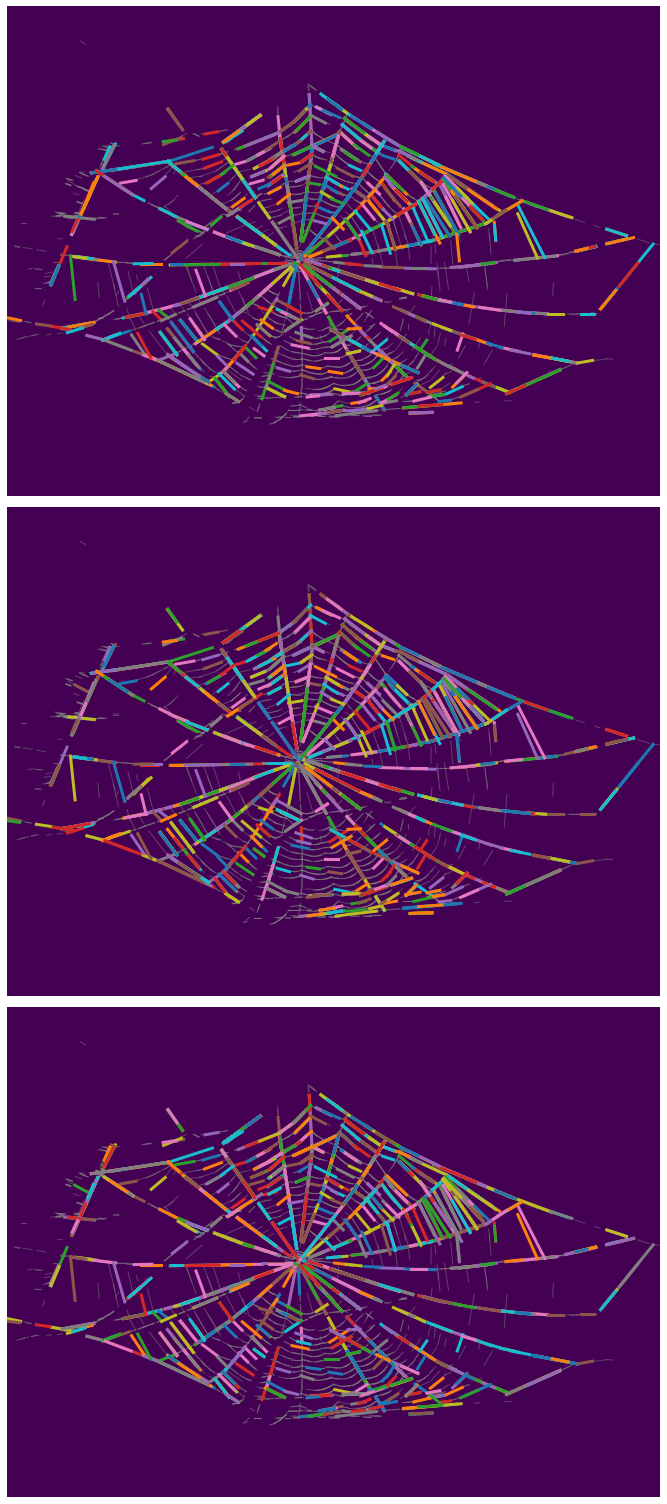

In [152]:
demofig = np.full(webpack.dimensions[::-1], 0, dtype=np.uint8)
fig,ax = plt.subplots(3, 1, figsize=[int(d/100) for d in webpack.dimensions])
ax[0].imshow(demofig)
ax[1].imshow(demofig)
ax[2].imshow(demofig)

for line in webpack.lines:
    p0, p1 = line
    ax[0].plot((p0[0], p1[0]), (p0[1], p1[1]), color='gray', lw=1, alpha=0.5)
for line in results:
    p0, p1 = line
    ax[0].plot((p0[0], p1[0]), (p0[1], p1[1]), lw=3)
ax[0].set_xlim((0, demofig.shape[1]))
ax[0].set_ylim((demofig.shape[0], 0))

for line in webpack.lines:
    p0, p1 = line
    ax[1].plot((p0[0], p1[0]), (p0[1], p1[1]), color='gray', lw=1, alpha=0.5)
for line in results2:
    p0, p1 = line
    ax[1].plot((p0[0], p1[0]), (p0[1], p1[1]), lw=3)
ax[1].set_xlim((0, demofig.shape[1]))
ax[1].set_ylim((demofig.shape[0], 0))

for line in webpack.lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]), color='gray', lw=1, alpha=0.5)
for line in results3:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]), lw=3)
ax[2].set_xlim((0, demofig.shape[1]))
ax[2].set_ylim((demofig.shape[0], 0))

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.tight_layout()
plt.show()

---

## The state of the (segment) union

Houston, we have a complex problem.

_Positives:_

- Segment merging sort of works
- We can also add a "min length" parameter

_Negatives:_

- Merge parameters are hard and seem to be behaving weirdly 
- We seem to be ADDING lines rather than excluding them
- We need to find ways to merge long lines recursively
    - We may have to rewrite the whole bloody algorithm to make this actually work.

---

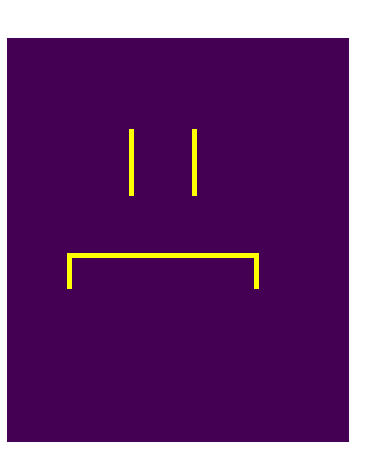

In [176]:
test_lines = (
    ((3, 4), (3, 5)),
    ((2, 4), (2, 5)),
    ((1, 3), (4, 3)),
    ((1, 2.5), (1, 3)),
    ((4, 2.5), (4, 3)),
)

demofig = np.full((7,6), 0, dtype=np.uint8)

fig,ax = plt.subplots(1, figsize=(8,8))
ax.imshow(demofig)
for line in test_lines:
    p0, p1 = line
    ax.plot((p0[0], p1[0]), (p0[1], p1[1]), lw=5, color="yellow")
ax.set_xlim((0, demofig.shape[1]))
ax.set_ylim((0, demofig.shape[0]))

ax.axis('off')
plt.show()